# 경사하강법

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

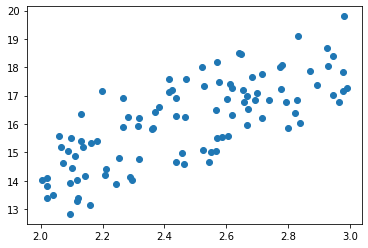

In [2]:
np.random.seed(0)
#w1=4,w2=6,y=4X+6 근사

X=2+np.random.rand(100,1)
y=6+4*X+np.random.randn(100,1)

#X,y 데이터 세트 산점도로 시각화
plt.scatter(X,y)

In [7]:
def get_cost(y,y_pred):
    N=len(y)
    cost=np.sum(np.square(y-y_pred)/N)
    return cost

def get_weight_updates(w1,w0,X,y,learning_rate=0.01):
    N=len(y)
    #w1,w0의shape과 동일한 크기를 가진 0값으로 초기화
    w1_update=np.zeros_like(w1)
    w0_update=np.zeros_like(w0)
    #예측 배열 계산, 예측과 실제 값 차이 계산
    y_pred=np.dot(X,w1.T)+w0
    diff=y-y_pred
    
    w0_factors=np.ones((N,1))
    w1_update=-(2/N)*learning_rate*(np.dot(X.T,diff))
    w0_update=-(2/N)*learning_rate*(np.dot(w0_factors.T,diff))
    
    return w1_update,w0_update

def gradient_descent_steps(X,y,iters=10000):
    w0=np.zeros((1,1))
    w1=np.zeros((1,1))
    
    for ind in range(iters):
        w1_update,w0_update=get_weight_updates(w1,w0,X,y,learning_rate=0.01)
        w1=w1-w1_update
        w0=w0-w0_update
        
    return w1,w0

w1,w0=gradient_descent_steps(X,y,iters=1000)
print("w1:{0:.3f} w0:{1:.3f}".format(w1[0,0],w0[0,0]))
y_pred=w1[0,0]*X+w0
print('Gradient Descent Total Cost:{0:.4f}'.format(get_cost(y,y_pred)))

w1:5.243 w0:3.082
Gradient Descent Total Cost:1.1356


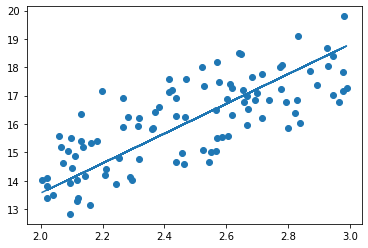

In [10]:
plt.scatter(X,y)
plt.plot(X,y_pred)

In [14]:
def stochastic_gradient_descent_steps(X,y,batch_size=10,iters=1000):
    w0=np.zeros((1,1))
    w1=np.zeros((1,1))
    prev_cost=100000
    iter_index=0
    
    for ind in range(iters):
        np.random.seed(ind)
        
        stochastic_random_index=np.random.permutation(X.shape[0])
        sample_X=X[stochastic_random_index[0:batch_size]]
        sample_y=y[stochastic_random_index[0:batch_size]]
        
        w1_update,w0_update=get_weight_updates(w1,w0,sample_X,sample_y,learning_rate=0.01)
        w1=w1-w1_update
        w0=w0-w0_update
        
        return w1,w0
    
w1,w0=stochastic_gradient_descent_steps(X,y,iters=1000)
print("w1:",round(w1[0,0],3),"w0:",round(w0[0,0],3))
y_pred=w1[0,0]*X+w0
print('Stochastic Gradient Descent Total Cost:{0:.4f}'.format(get_cost(y,y_pred)))

w1: 0.702 w0: 0.301
Stochastic Gradient Descent Total Cost:199.1531


# LinearRegression을 이용해 보스턴 주택 가격 회귀 구현

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

### 데이터 살펴보기

In [19]:
boston=load_boston()
bostonDF=pd.DataFrame(boston.data,columns=boston.feature_names)
bostonDF['PRICE']=boston.target
print('Boston 데이터 세트 크기 :',bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [20]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


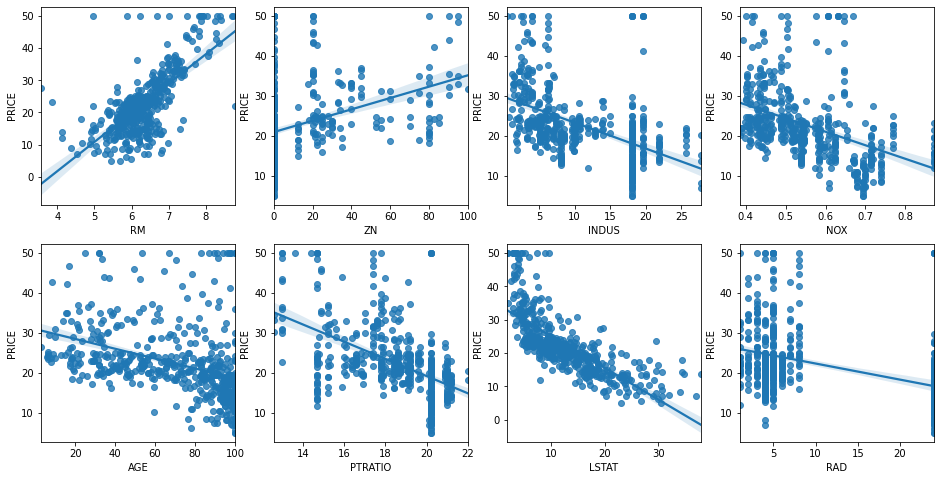

In [21]:
#각 칼럼이 회귀 결과에 미치는 영향이 어느정도인지 시각화
fig,axs=plt.subplots(figsize=(16,8),ncols=4,nrows=2)
lm_features=['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i, feature in enumerate(lm_features):
    row=int(i/4)
    col=i%4
    sns.regplot(x=feature,y='PRICE',data=bostonDF,ax=axs[row][col])

### 회귀 모델 만들기

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'],axis=1,inplace=False)

X_train,X_test,y_train,y_test=train_test_split(X_data,y_target,test_size=0.3,random_state=156)

lr=LinearRegression()
lr.fit(X_train,y_train)
y_preds=lr.predict(X_test)
mse=mean_squared_error(y_test,y_preds)
rmse=np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse,rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test,y_preds)))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757


In [24]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:',np.round(lr.coef_,1))

절편 값: 40.995595172164336
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [25]:
#회귀 계수 정렬
coeff=pd.Series(data=np.round(lr.coef_,1),index=X_data.columns)
coeff.sort_values(ascending=False)

#NOX 값 너무 큼

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [33]:
from sklearn.model_selection import cross_val_score

y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'],axis=1,inplace=False)
lr=LinearRegression()

neg_mse_scores=cross_val_score(lr,X_data,y_target,scoring="neg_mean_squared_error",cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores: ',np.round(neg_mse_scores,2))
print('5 folds 의 개별 RMSE scores: ',np.round(rmse_scores,2))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds 의 개별 RMSE scores:  [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE: 5.829


## 다항회귀

In [36]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

#다항식으로 변환한 단항식 생석, 2X2 행렬 생성
X=np.arange(4).reshape(2,2)
print('일차 단항식 계수 피처:\n',X)

#degree=2, 2차 다항식으로 변환
#[1,x1,x2,x1^2,x1x2,x2^2]
poly=PolynomialFeatures(degree=2)
poly.fit(X)
poly_ftr=poly.transform(X)
print('변환된 2차 다항식 계수 피처:\n',poly_ftr)

일차 단항식 계수 피처:
 [[0 1]
 [2 3]]
변환된 2차 다항식 계수 피처:
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


In [42]:
def polynomial_func(X):
    y=1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
    return y

X=np.arange(4).reshape(2,2)
print('일차 단항식 계수 feature: \n',X)
y=polynomial_func(X)
print('삼차 다항식 결정값: \n',y)

#3차 다항식 변환
#[1,x1,x2,x1^2,x1x2,x2^2,x1^3,x1^2*x1,x1*x2^2,x1^3]
poly_ftr=PolynomialFeatures(degree=3).fit_transform(X)
print('3차 다항식 계수 feature: \n',poly_ftr)

model=LinearRegression()
model.fit(poly_ftr,y)
print('Polynomial 회귀 계수\n',np.round(model.coef_,2))
print('Polynomial 회귀 Shape :',model.coef_.shape)

일차 단항식 계수 feature: 
 [[0 1]
 [2 3]]
삼차 다항식 결정값: 
 [  5 125]
3차 다항식 계수 feature: 
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
Polynomial 회귀 Shape : (10,)


In [45]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np

def polynomial_func(X):
    y=1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
    return y

model=Pipeline([('poly',PolynomialFeatures(degree=3)),
               ('linear',LinearRegression())])
X=np.arange(4).reshape(2,2)
y=polynomial_func(X)

model=model.fit(X,y)

print('Polynomial 회귀 계수\n',np.round(model.named_steps['linear'].coef_,2))

Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]


## 과적합 문제

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
%matplotlib inline

def true_fun(X):
    return np.cos(1.5*np.pi*X)

np.random.seed(0)
n_samples=30
X=np.sort(np.random.rand(n_samples))

y=true_fun(X)+np.random.randn(n_samples)*0.1

In [49]:
plt.figure(figsize=(14,5))
degress=[1,4,15]

for i in range(len(degrees)):
    ax=plt.subplot(1,len(degrees),i+1)
    plt.setp(ax,xticks=(),yticks=())
    
    polynomial_features=PolynomialFeatures(degree=degrees[i],include_bias=False)
    linear_regression=LinearRegression()
    pipeline=Pipeline([("polynomia_features",polynomial_features),
                      ("linear_regression",linear_regression)])
    pipeline.fit(X.reshape(-1,1),y)
    
    scores=cross_val_score(pipeline,X.reshape(-1,1),y,scoring="neg_mean_squared_error",cv=10)
    coefficients=pipeline.named_steps['linear_regression'].coef_
    print('\n Degree {0} 회귀계수는 {1}입니다.'.format(degrees[i],np.round(coefficients,2))
    print('Degree {0} MSE는 {1}입니다.'.format(degrees[i],-1*np.mean(scores)))
          
    X_test=np.linspace(0,1,100)
    plt.plot(X_test,pipeline.predict(X_test[:,np.newaxis]),label="Model")
          
    plt.plot(X_test,true_fun(X_test),'--',label="True function")
    plt.scatter(X,y,edgecolor='b',s=20,label="Samples")
          
    plt.xlabel("x"); plt.ylabel("y"); plt.xlim((0,1)); plt.ylim((-2,2)); plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(degress[i],-scores.mean(),scores.std()))
          
plt.show()

SyntaxError: invalid syntax (<ipython-input-49-72bd3b733503>, line 19)

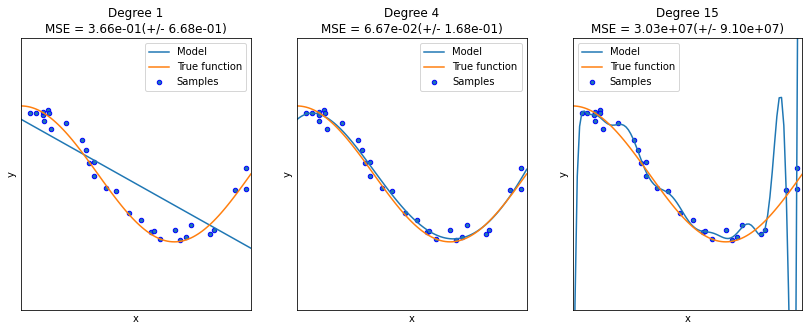

In [50]:
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x"); plt.ylabel("y"); plt.xlim((0, 1)); plt.ylim((-2, 2)); plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(degrees[i], -scores.mean(), scores.std())
             )
plt.show()